# This notebook looks at the DOE of SOLD libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from scipy.spatial.distance import hamming

amino_acids = list(IUPACData.protein_letters)


# For simulation, create a random parent amino acid sequence to create SOLD libraries from

In [2]:
length_of_protein = 100
parent = ''.join(np.random.choice(amino_acids, length_of_protein))
print("Parent protein:", parent) 

Parent protein: CNPIQLMSTVQLLSFWCEKQAGYHQSCKYRDFAGYAEDYSFLVWMVAAYPPCWWKTTWLTFWQPFCTWYLTEEFHMTKGNHDIMHCIIDVNNPYPPMGMW


# Need to create a matrix of postion vs letters

In [3]:
num_mutated = 20 
mutated_pos = np.sort(np.random.choice(range(length_of_protein), num_mutated))
print(mutated_pos) 

[ 3  8 10 11 17 18 26 27 37 37 40 42 54 58 58 59 79 84 86 97]


## For every poisiton to mutate choose a few amino acids to mutate to, with parent amino acid at that pos. to be most probable 

In [4]:
random_muts = [] 
num_muts = 3 
parent_prob = 0.85
mut_probs = [0.05, 0.05, 0.05] # I am keeping it simple here 
assert np.sum(mut_probs) + parent_prob == 1

mut_dict = defaultdict(dict) 
for i in mutated_pos: 
    draws = list(amino_acids) 
    draws.remove(parent[i]) 
    to_draw = np.random.choice(draws, num_muts, replace = False) 
    mut_dict[int(i)] = {parent[i]: parent_prob} 
    for k,l in enumerate(to_draw):
        mut_dict[int(i)].update({str(l): mut_probs[k]})

In [5]:
# Create mutation matrix 
sold_mat = np.zeros((len(amino_acids), length_of_protein))
for k,v in mut_dict.items(): 
    for base, prob in v.items(): 
        sold_mat[amino_acids.index(base), k] = prob


sold_mat_df = pd.DataFrame(sold_mat, index = amino_acids, columns = np.arange(length_of_protein))
sold_mat_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
C,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
D,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0
E,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
F,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


# Plot the SOLD matrix 

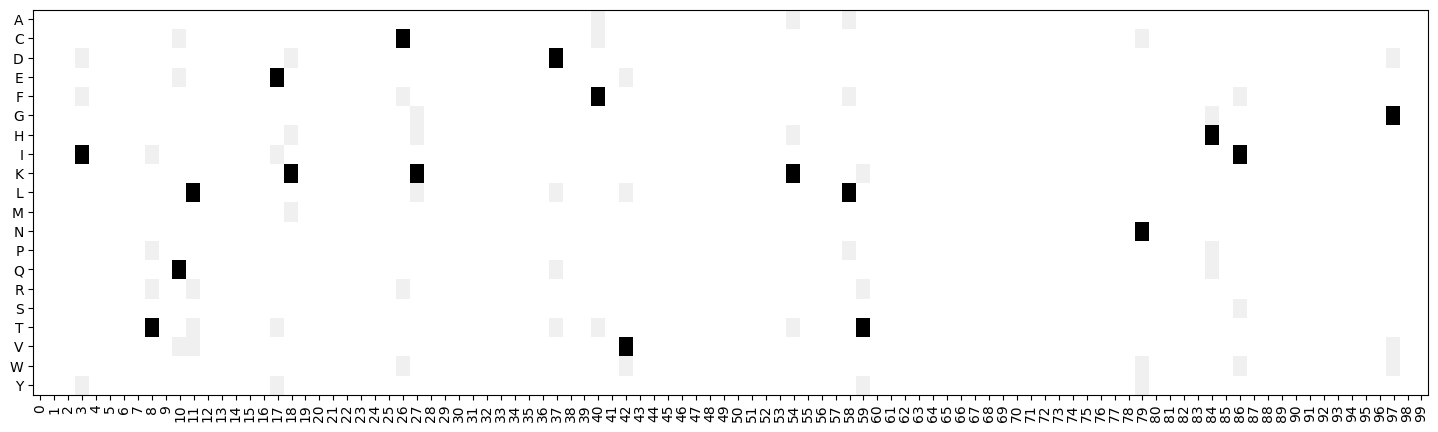

In [6]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(amino_acids)), amino_acids)


# Now let's try to draw mutated sequences from this matrix 
## Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentaliat provided SOLD mat

In [62]:
def hamming_dist(seq1, seq2): 
    """
    compute hamming distance (number of mutations) for same length sequences 
    """
    return len(seq1)*hamming(list(seq1), list(seq2))


def get_n_choose_m_indices(n, m):
    """
    Generates all unique combinations of m indices chosen from a set of n indices (0 to n-1).

    Args:
        n (int): The total number of elements (or indices) available.
        m (int): The number of elements (or indices) to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple represents a unique combination of m indices.
    """
    if not (0 <= m <= n):
        raise ValueError("m must be between 0 and n (inclusive).")

    # Generate indices from 0 to n-1
    indices = range(n)

    # Use itertools.combinations to get all combinations of m indices
    combinations_iterator = itertools.combinations(indices, m)

    # Convert the iterator to a list of tuples
    return list(combinations_iterator)



class SOLD: 
    """
    Class to deal with all the fucntionalities, given SOLD library specs, to create simulations and probability distributions 
    """
    def __init__(self, sold_mat_df): 
        """
        Expect a dataframe with amino acid single letter code in rows and positions (zero indexed) for columns---see example above 
        """
        amino_acids = sold_mat_df.index.values.astype(str)
        positions = sold_mat_df.columns.astype(int)
        mat = sold_mat_df.to_numpy()
        parent = {}   
        mutation_probs = defaultdict(dict)  
        all_parent_probs = [] 
        for i,r in enumerate(positions):
            probs = mat[:,i] 
            if np.any(probs): 
                assert np.allclose(np.sum(probs), 1), "expected probabilities: check column " + np.str(r) 
                #check that these are probs 
                parent_prob = np.max(probs) 
                all_parent_probs.append(parent_prob) 
                parent_aa = amino_acids[np.argmax(probs)] 
                parent[r] = str(parent_aa)
                inds = np.flatnonzero(probs) 
                mutation_probs[r] = {str(amino_acids[i]):float(probs[i]) for i in inds} 
        self.mutation_probs = mutation_probs
        self.parent = parent
        parent_seq = ['N']*len(parent) 
        #making sure this is done robustly in case data entry is not in order
        parent_pos = list(np.sort(list(parent.keys())))
        for i, v in parent.items():
            parent_seq[parent_pos.index(i)] = v
        self.parent_seq = ''.join(parent_seq)  
        self.mut_positions = parent_pos 
        self.all_parent_probs = all_parent_probs
        
    def compute_prob_n_mutations(self, N): 
        """
        Compute the probability of seeing N mutations 
        """
        # number of positions 
        M = len(self.all_parent_probs)
        # get indices of mutations
        mut_probs = np.zeros(N) 
        all_parent_probs = np.copy(self.all_parent_probs) 
        for i in range(N): 
            # find which indices of the positions are mutated 
            mutated_indices = get_n_choose_m_indices(M, i) 
            total_mut_prob = 0
            for k in mutated_indices: 
                loc_all_probs = np.copy(all_parent_probs) 
                loc_all_probs[list(k)] = 1 - all_parent_probs[list(k)] 
                total_mut_prob += np.prod(loc_all_probs) 
            mut_probs[i] = total_mut_prob
        return mut_probs
        
    def generate_sequences(self, N): 
        """
        generate N sequences 
        Args:
            N: number of sequences to generate 
        """
        collector = np.empty((N,len(self.mut_positions)), dtype = str) 
        max_probs = [] 
        for pos, v in self.mutation_probs.items():
            choices = list(v.keys())
            probs = list(v.values())
            max_probs.append(max_probs) 
            index = self.mut_positions.index(pos) # find the index of the position to fill 
            loc_seq = np.random.choice(choices, N, p = probs) 
            collector[:, index] = loc_seq
        seqs = [''.join(s) for s in collector] 
        mutations = [hamming_dist(self.parent_seq, s) for s in seqs]   
        # compute the probability of mutations 
        
        return seqs, mutations

    def compute_hamming_distance(self, seqs, parent): 
        """
        Args: 
            seqs
            parent seq  
        """
        dist = [] 
        for s in seqs: 
            dist.append(hamming_dist(s, parent)) 
        return dist 
        

In [62]:
def hamming_dist(seq1, seq2): 
    """
    compute hamming distance (number of mutations) for same length sequences 
    """
    return len(seq1)*hamming(list(seq1), list(seq2))


def get_n_choose_m_indices(n, m):
    """
    Generates all unique combinations of m indices chosen from a set of n indices (0 to n-1).

    Args:
        n (int): The total number of elements (or indices) available.
        m (int): The number of elements (or indices) to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple represents a unique combination of m indices.
    """
    if not (0 <= m <= n):
        raise ValueError("m must be between 0 and n (inclusive).")

    # Generate indices from 0 to n-1
    indices = range(n)

    # Use itertools.combinations to get all combinations of m indices
    combinations_iterator = itertools.combinations(indices, m)

    # Convert the iterator to a list of tuples
    return list(combinations_iterator)



class SOLD: 
    """
    Class to deal with all the fucntionalities, given SOLD library specs, to create simulations and probability distributions 
    """
    def __init__(self, sold_mat_df): 
        """
        Expect a dataframe with amino acid single letter code in rows and positions (zero indexed) for columns---see example above 
        """
        amino_acids = sold_mat_df.index.values.astype(str)
        positions = sold_mat_df.columns.astype(int)
        mat = sold_mat_df.to_numpy()
        parent = {}   
        mutation_probs = defaultdict(dict)  
        all_parent_probs = [] 
        for i,r in enumerate(positions):
            probs = mat[:,i] 
            if np.any(probs): 
                assert np.allclose(np.sum(probs), 1), "expected probabilities: check column " + np.str(r) 
                #check that these are probs 
                parent_prob = np.max(probs) 
                all_parent_probs.append(parent_prob) 
                parent_aa = amino_acids[np.argmax(probs)] 
                parent[r] = str(parent_aa)
                inds = np.flatnonzero(probs) 
                mutation_probs[r] = {str(amino_acids[i]):float(probs[i]) for i in inds} 
        self.mutation_probs = mutation_probs
        self.parent = parent
        parent_seq = ['N']*len(parent) 
        #making sure this is done robustly in case data entry is not in order
        parent_pos = list(np.sort(list(parent.keys())))
        for i, v in parent.items():
            parent_seq[parent_pos.index(i)] = v
        self.parent_seq = ''.join(parent_seq)  
        self.mut_positions = parent_pos 
        self.all_parent_probs = all_parent_probs
        
    def compute_prob_n_mutations(self, N): 
        """
        Compute the probability of seeing N mutations 
        """
        # number of positions 
        M = len(self.all_parent_probs)
        # get indices of mutations
        mut_probs = np.zeros(N) 
        all_parent_probs = np.copy(self.all_parent_probs) 
        for i in range(N): 
            # find which indices of the positions are mutated 
            mutated_indices = get_n_choose_m_indices(M, i) 
            total_mut_prob = 0
            for k in mutated_indices: 
                loc_all_probs = np.copy(all_parent_probs) 
                loc_all_probs[list(k)] = 1 - all_parent_probs[list(k)] 
                total_mut_prob += np.prod(loc_all_probs) 
            mut_probs[i] = total_mut_prob
        return mut_probs
        
    def generate_sequences(self, N): 
        """
        generate N sequences 
        Args:
            N: number of sequences to generate 
        """
        collector = np.empty((N,len(self.mut_positions)), dtype = str) 
        max_probs = [] 
        for pos, v in self.mutation_probs.items():
            choices = list(v.keys())
            probs = list(v.values())
            max_probs.append(max_probs) 
            index = self.mut_positions.index(pos) # find the index of the position to fill 
            loc_seq = np.random.choice(choices, N, p = probs) 
            collector[:, index] = loc_seq
        seqs = [''.join(s) for s in collector] 
        mutations = [hamming_dist(self.parent_seq, s) for s in seqs]   
        # compute the probability of mutations 
        
        return seqs, mutations

    def compute_hamming_distance(self, seqs, parent): 
        """
        Args: 
            seqs
            parent seq  
        """
        dist = [] 
        for s in seqs: 
            dist.append(hamming_dist(s, parent)) 
        return dist 


    
        

In [63]:
S = SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(1000)

In [64]:
a= S.compute_prob_n_mutations(10)

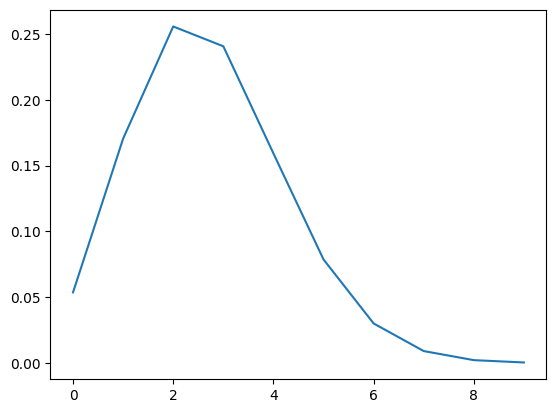

In [65]:
plt.plot(a)

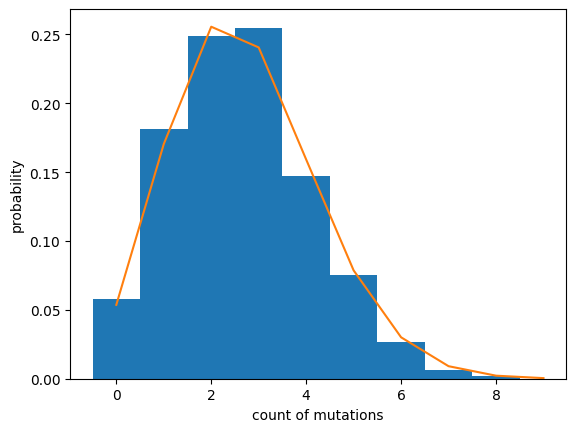

In [71]:
plt.hist(mutations, bins= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], density = True, align = "left") 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(a)

In [10]:
dist = S.compute_hamming_distance(seqs, S.parent_seq) 

(array([ 58., 174., 279., 223., 157.,  69.,  29.,   8.,   3.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

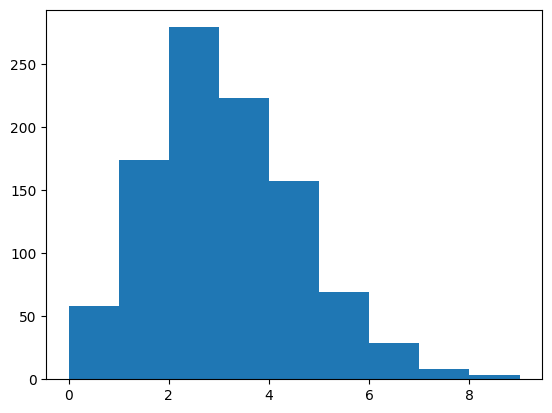

In [11]:
plt.hist(dist, bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
hamming_dist(seqs[0], S.parent_seq)

np.float64(5.0)

In [13]:
positions = sold_mat_df.columns.astype(int)
positions

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='int64')

In [14]:
sold_mat_df.to_numpy()

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], shape=(20, 100))

In [15]:
np.random.choice(['A', 'C', 'G', 'T'], 3, p = [0.85, 0.05, 0.05, 0.05])

array(['T', 'A', 'A'], dtype='<U1')

In [17]:
import itertools

def get_n_choose_m_indices(n, m):
    """
    Generates all unique combinations of m indices chosen from a set of n indices (0 to n-1).

    Args:
        n (int): The total number of elements (or indices) available.
        m (int): The number of elements (or indices) to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple represents a unique combination of m indices.
    """
    if not (0 <= m <= n):
        raise ValueError("m must be between 0 and n (inclusive).")

    # Generate indices from 0 to n-1
    indices = range(n)

    # Use itertools.combinations to get all combinations of m indices
    combinations_iterator = itertools.combinations(indices, m)

    # Convert the iterator to a list of tuples
    return list(combinations_iterator)

# Example usage:
N_value = 5  # Total number of elements
M_value = 2  # Number of elements to choose

result_indices = get_n_choose_m_indices(N_value, M_value)
print(f"Combinations of {N_value} choose {M_value} indices:")
print(result_indices)

N_value_2 = 4
M_value_2 = 3
result_indices_2 = get_n_choose_m_indices(N_value_2, M_value_2)
print(f"\nCombinations of {N_value_2} choose {M_value_2} indices:")
print(result_indices_2)

Combinations of 5 choose 2 indices:
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

Combinations of 4 choose 3 indices:
[(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]


In [23]:
result_indices = get_n_choose_m_indices(10, 2)
result_indices

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 8),
 (7, 9),
 (8, 9)]

In [35]:
a = np.arange(10) 
a[list(result_indices[0])] 

array([0, 1])

In [38]:
b = np.copy(a) 
b[list(result_indices[0])] = 1 - a[list(result_indices[0])]

In [39]:
b

array([1, 0, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])